**POZNÁMKA: Tento notebook je určený pre platformu Google Colab, ktorá zdarma poskytuje hardvérovú akceleráciu. Je však možné ho spustiť (možno s drobnými úpravami) aj ako štandardný Jupyter notebook, pomocou lokálnej grafickej karty.** 



In [ ]:
#@title -- Installation of Packages -- { display-mode: "form" }
import sys
!{sys.executable} -m pip install --quiet git+https://github.com/michalgregor/class_utils.git
!{sys.executable} -m pip install --quiet git+https://github.com/greentfrapp/lucent.git

In [ ]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

from lucent.optvis import render, param, transform, objectives
from torchvision import models
from lucent.misc.io import show
from lucent.optvis.objectives import wrap_objective
from lucent.modelzoo.util import get_model_layers

try:
    from google.colab import files
except ModuleNotFoundError:
    pass

In [ ]:
#@title -- Downloading Data -- { display-mode: "form" }
from class_utils.download import download_file_maybe_extract
DATA_HOME = "https://github.com/michalgregor/ml_notebooks/blob/main/data/{}?raw=1"

download_file_maybe_extract(DATA_HOME.format("images/cat.jpg"), directory="data")
download_file_maybe_extract(DATA_HOME.format("images/picaso.jpg"), directory="data")

# also create a directory for storing any outputs
import os
os.makedirs("output", exist_ok=True)

In [ ]:
#@title -- Auxiliary Functions -- { display-mode: "form" }
def resize(img, max_size=500):
    if img.size[0] > img.size[1]:
        size = (max_size, int(img.size[1] / img.size[0] * max_size))
    else:
        size = (int(img.size[0] / img.size[1] * max_size), max_size)

    return img.resize(size)

def resize_to_fit(img, size):
    aspect0 = size[0] / img.size[0]
    aspect1 = size[1] / img.size[1]

    img_aspect0_1 = int(np.ceil(aspect0 * img.size[1]))
    if img_aspect0_1 >= size[1]:
        new_size = (size[0], img_aspect0_1)
    else:
        img_aspect1_0 = int(np.ceil(aspect1*img.size[0]))
        new_size = (img_aspect1_0, size[1])

    return img.resize(new_size)

def preproc_img(img):
    return np.asarray(img) / 255

def show_images(imgs, figsize=(15, 6), clip=False, titles=None):
    assert(len(imgs == 3))
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(figsize)
    axes = np.reshape(axes, -1)
    titles = titles or ["generated image", "content image", "style image"]

    for img, ax, title in zip(imgs, axes, titles):
        if clip:
            img = np.clip(img*255, 0, 255).astype('uint8')
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(title)

    for ax in axes[len(imgs):]:
        ax.axis('off')

    plt.tight_layout()
    return fig

def style_transfer_param(
    content_image, style_image,
    decorrelate=True, fft=True,
    callback=None
):
    content_image_res = resize(content_image, max_size=500)
    style_image_res = resize_to_fit(style_image, content_image_res.size)
    content_image_pre = preproc_img(content_image_res)
    style_image_pre = preproc_img(style_image_res)

    shape = content_image_pre.shape[:2] # assume we use content_image.shape
    params, image = param.image(*shape, decorrelate=decorrelate, fft=fft)
    
    def inner():
        style_transfer_input = image()[0].permute((0, 2, 1)) # swap width and height
        content_input = torch.tensor(np.transpose(content_image_pre, [2, 0, 1])).float().to(device)
        style_input = torch.tensor(np.transpose(style_image_pre[:shape[0], :shape[1], :], [2, 0, 1])).float().to(device)
        stack = torch.stack([style_transfer_input, content_input, style_input])

        if not callback is None:
            callback(stack)

        return stack
    
    return params, inner

# following the original Lucid notebook,
# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
CONTENT_INDEX = 1
STYLE_INDEX = 2

def mean_L1(a, b):
    return torch.abs(a-b).mean()

@wrap_objective()
def activation_difference(layer_names, activation_loss_f=mean_L1, transform_f=None, difference_to=CONTENT_INDEX):
    def inner(T):
        # first we collect the (constant) activations of image we're computing the difference to
        image_activations = [T(layer)[difference_to] for layer in layer_names]
        if transform_f is not None:
            image_activations = [transform_f(act) for act in image_activations]

        # we also set get the activations of the optimized image which will change during optimization
        optimization_activations = [T(layer)[TRANSFER_INDEX] for layer in layer_names]
        if transform_f is not None:
            optimization_activations = [transform_f(act) for act in optimization_activations]

        # we use the supplied loss function to compute the actual losses
        losses = [activation_loss_f(a, b) for a, b in zip(image_activations, optimization_activations)]
        return sum(losses)

    return inner

def total_variation_loss(img, beta=2):
    bs_img, c_img, h_img, w_img = img.size()
    tv_h = torch.pow(img[:,:,1:,:-1]-img[:,:,:-1,:-1], 2)
    tv_w = torch.pow(img[:,:,:-1,1:]-img[:,:,:-1,:-1], 2)
    tv = torch.pow(tv_h + tv_w, beta / 2).sum()
    return tv/(bs_img*c_img*h_img*w_img)

@objectives.wrap_objective()
def tv_objective(beta=2, layer='input', batch=None):
    @objectives.handle_batch(batch)
    def inner(T):
        return total_variation_loss(T(layer), beta=beta)
    return inner

def lp_loss(img, p=6, ref=0):
    if np.isinf(p):
        return torch.max(img)
    return torch.pow(torch.sum(torch.pow(torch.abs(img - ref), p)), 1/p)

@objectives.wrap_objective()
def lp_objective(p=6, ref=0, layer='input', batch=None):
    @objectives.handle_batch(batch)
    def inner(model):
        return lp_loss(model(layer), p=p, ref=ref)
    return inner

def gram_matrix(features, normalize=True):
    C, H, W = features.shape
    features = features.view(C, -1)
    gram = torch.matmul(features, torch.transpose(features, 0, 1))
    if normalize:
        gram = gram / (H * W)
    return gram

## Neurálny transfer štýlu

Tento notebook ilustruje ako sa dá použiť algoritmus neurálneho umeleckého štýlu z [[neural_art]](#neural_art). Na jeho implementáciu použijeme nástoje z PyTorch-ového framework-u [lucent](https://github.com/greentfrapp/lucent). Budeme tiež využívať niektoré časti kódu z ich tutoriálu, ktorý môžete nájsť [tu](https://colab.research.google.com/github/greentfrapp/lucent-notebooks/blob/master/notebooks/style_transfer.ipnb).

Neurálny transfer štýlu je technika, kde sa vstupný obrázok prekresľuje do štýlu iného obrázka. Príklad vidno na obrázku nižšie, kde sa obrázok s obsahom, na ktorom je mačka, transformuje do štýlu Kandinského maľby.

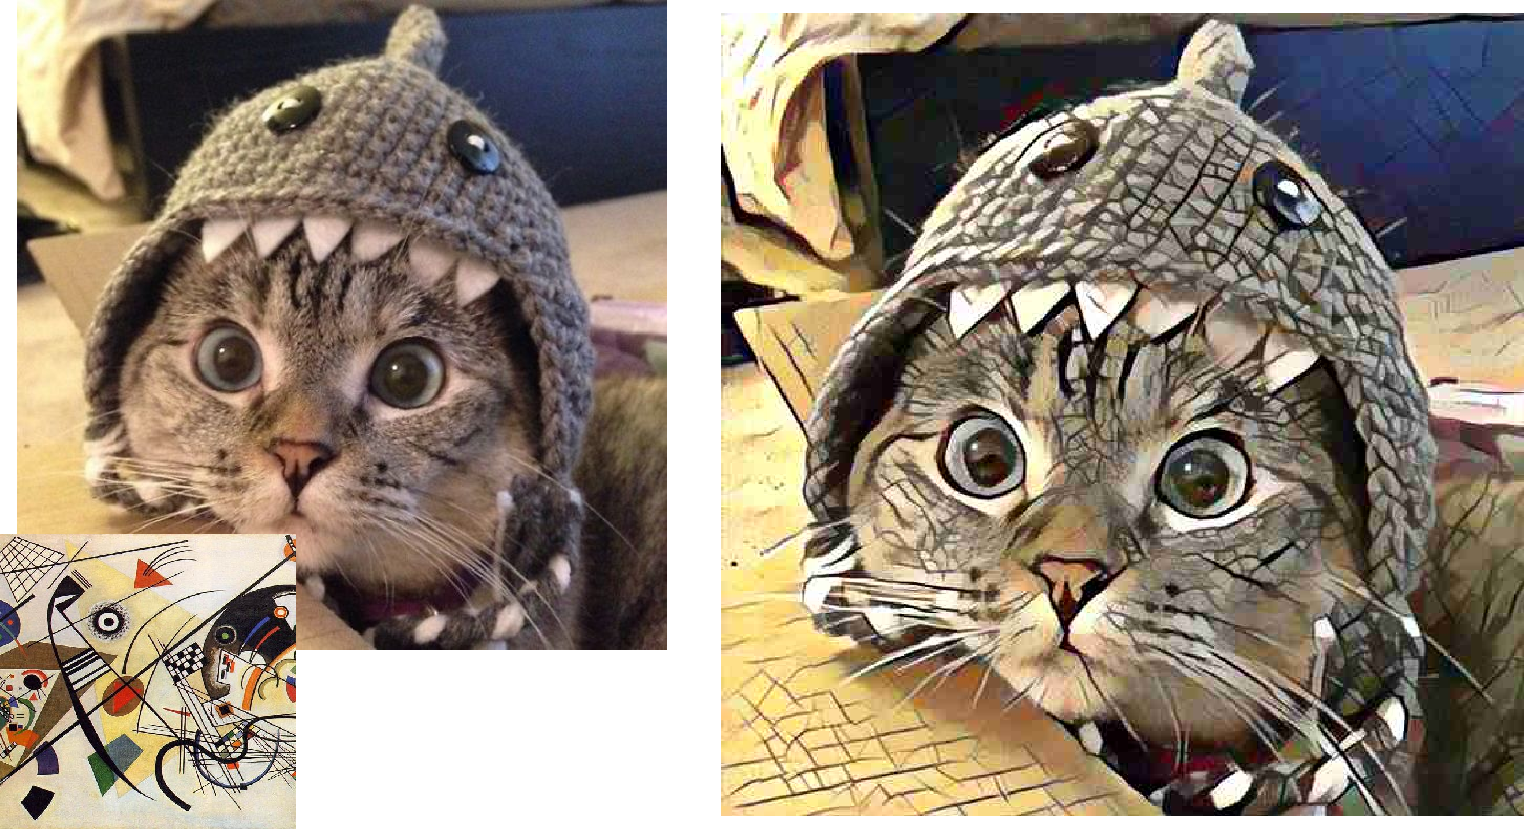

### Základná idea

Spomínaná metóda využíva neurónovú sieť predtrénovanú na rozpoznávanie obrazu na dátovej množine ImageNet. Taká sieť má konvolučné vrstvy, ktoré uže sú schopné extrahovať zo vstupného obrázka relevantné príznaky a vzory. Čo potom môžeme urobiť je, že na vstup siete dáme obrázok s obsahom a obrázok so štýlom a sledujeme aké "odtlačky" zanechajú vo vybraných vrstvách siete.

Následne začneme s náhodne generovaným šumovým obrázkom a pomocou gradientov ho optimalizujeme tak, aby sa jeho odtlačky podobali na oboje: na odtlačky obrázka s obsahom a na odtlačky obrázka so štýlom. Prirodzene, pre obrázok so štýlom sa budeme pozerať na trochu iný typ odtlačkov – inak by sme jednoducho vytvorili zmes obsahu z oboch obrázkov.

Aby sa dostal k štýlu obrázka, využíva článok [[neural_art]](#neural_art) *Gram maticu*  (angl. Gram matrix), ktorá sleduje koreláciu príznakov vo vrstve. Neformálne možno povedať, že zachováva informáciu o textúre, ale nie o globálnom usporiadaní obrázka [[neural_art]](#neural_art).

#### Kritérium pre obsah

Skúsme teraz tieto myšlienky trochu konkretizovať zavedením niekoľkých formálnych definícií. Ako vieme, kritérium pre obsah bude založené na vzdialenosti medzi príznakmi generovaného obrázka $\mathbf{x}$ a pôvodného obrázka $\mathbf{p}$. Ak použijeme $F^l$ a $P^l$ na označenie príznakových máp produkovaných vrstvou $l$ pre generovaný obrázok $\mathbf{x}$ a pôvodný obrázok $\mathbf{p}$, potom môžeme kritérium pre obsah vo vrstve $l$ definovať ako [[neural_art]](#neural_art):

$$
\mathcal{L}_\text{content}(\mathbf{p}, \mathbf{x}, l) = \frac{1}{2} \sum_{i,j} \left( F^l_{ij} - P^l_{ij} \right)^2,
$$
kde $i$ je index filtra (pripomeňme si, že každá konvolučná vrstva má viacero filtrov a každý z nich produkuje vlastnú príznakovú mapu) a $j$ označuje konkrétny prvok príznakovej mapy daného filtra.

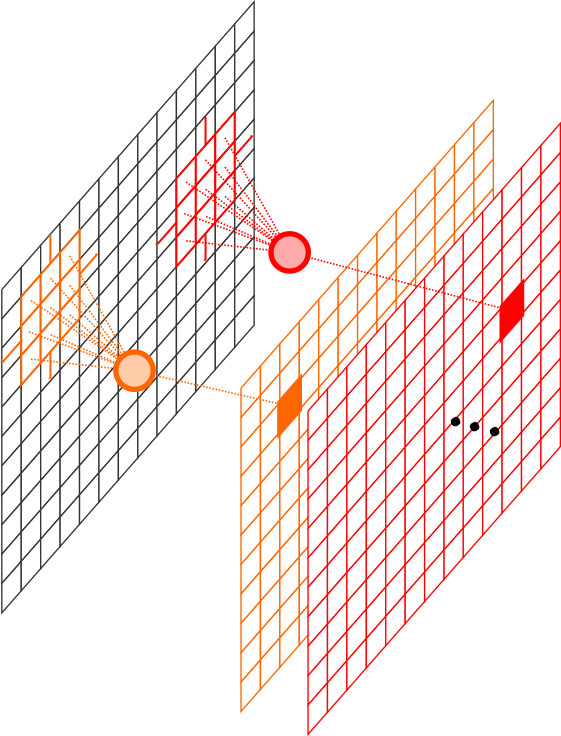

<center>Konvolu&#269;n&#225; vrstva: po vstupnom obraze k&#314;&#382;e viacero konvolu&#269;n&#253;ch filtrov a ka&#382;d&#253; z nich produkuje pr&#237;znakov&#250; mapu.</center>Upozornime, že kľúčovou ideou tu samozrejme je minimalizácia vzdialenosti medzi príznakmi oboch obrázkov. Je menej dôležité či sa vzdialenosť meria v zmysle súčtu kvadratických chýb, strednej absolútnej chyby (ktorú v skutočnosti používame v rámci našej implementácie) alebo ešte úplne inej metriky: všetko sú to zaujímavé možnosti, ktoré môžu vyprodukovať kvalitatívne odlišné výsledky.

#### Kritérium pre štýl

Kritérium pre štýl je založené na Gram matici $G^l$, o ktorej sme už hovorili: zachytáva korelácie medzi príznakmi a je definovaná takto [[neural_art]](#neural_art):

$$
G^l_{ij} = \sum_k F^l_{ik} F^l_{jk}.
$$
kde $i$ a $j$ zodpovedajú dvom príznakovým mapám vrstvy $l$.

Ak generovaný obrázok znova označíme $\mathbf{x}$, obrázok so štýlom $\mathbf{a}$ a ak $G^l$, $A^l$ budú ich príslušné Gram matice, potom príspevok vrstvy $l$ ku kritériu pre štýl sa dá vyjadriť takto [[neural_art]](#neural_art):

$$
e_l = \frac{1}{4 N_l^2 M_l^2} \sum_{i,j} ( G_{ij}^l - A_{ij}^l )^2,
$$
kde $N_l$ je počet príznakových máp vo vrstve $l$ a $M_l$ je veľkosť jednej príznakovej mapy vo vrstve $l$ (jej šírka krát jej výška).

Celkové kritérium pre štýl potom vyzerá takto [[neural_art]](#neural_art):
$$
\mathcal{L}*\text{style}(\mathbf{a}, \mathbf{x}) = \sum* {l} w_l e_l,
$$
kde $w_l$ je váha, ktorú priraďujeme každej vrstve $l$.

#### Celkové kritérium

Celkové kritérium pre neurálny transfer štýlu sa potom definuje jednoducho ako súčet oboch – kritéria pre obsah a kritéria pre štýl [[neural_art]](#neural_art):

$$
\mathcal{L}_\text{total}(\mathbf{p}, \mathbf{a}, \mathbf{x}) =
    \alpha \mathcal{L}_\text{content}(\mathbf{p}, \mathbf{x}) +
    \beta \mathcal{L}_\text{style}(\mathbf{a}, \mathbf{x}).
$$
### Implementácia pomocou PyTorch

Ďalej ukážeme ako sa dá neurálny transfer štýlu implementovať v rámci balíčka `PyTorch` pomocou nástroja `lucent`. Na začiatok pripravíme výpočtové zariadenie a načítame predtrénovanú sieť (v tomto prípade VGG-16). Sieť tiež uvedieme do evaluačného režimu, keďže ho nejdeme trénovať.



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = models.VGG16_Weights.IMAGENET1K_V1
model = models.vgg16(weights=weights)
model.to(device).eval();

#### Načítanie obrázkov

Následne načítame obrázok s obsahom a obrázok so štýlom. Začnime obrázkom s obsahom:



In [ ]:
content_image = Image.open("data/cat.jpg")
content_image

Odkomentujte a spustite nasledujúcu bunku ak chcete nahrať iný obrázok s obsahom. Prípustné je vybrať **len 1 obrázok** .



In [ ]:
# img_path = files.upload()
# content_image = Image.open(list(img_path)[0])
# content_image

Ďalej načítame obrázok so štýlom:



In [ ]:
style_image = Image.open("data/picaso.jpg")
style_image

In [ ]:
# img_path = files.upload()
# style_image = Image.open(list(img_path)[0])
# style_image

#### Generovanie preštýlovaného obrázka

Ďalej potrebujeme vytvoriť účelovú funkciu. Aby sme to mohli urobiť, budeme potrebovať príznaky z niektorých vrstiev $l$ – preto teraz špecifikujeme ich názvy (pokojne vyskúšajte aj iné vrstvy; ich úplný zoznam sa dá získať pomocou funkcie `get_model_layers(model)`). Vytvoríme si dva osobitné zoznamy – jeden s názvami vrstiev do kritéria pre obsah a druhý do kritéria pre štýl.



In [ ]:
content_layers = [
  'features_16'
]

style_layers = [
  'features_3',
  'features_5',
  'features_8',
  'features_12',
  'features_15'
]

Následne, podobne ako v predošlom notebook-u o predobrazoch, si vytvoríme účelovú funkciu. V tomto prípade v nej použijeme kritérium pre obsah, kritérium pre štýl založené na Gram matici a tiež celkovú variáciu (total variation) a $L^p$ normu z notebook-u o predobrazoch.

Parametrizácia `style_transfer_param` stavia na funkcii `param.image`, ibaže berie do úvahy aj obrázok s obsahom `content_image` a obrázok so štýlom `style_image`: navracia vlastne pole, kde sú všetky tri stohované v rámci dávkového rozmer, pričom obrázok s obsahom je na pozícii CONTENT_INDEX, obrázok so štýlom je na pozícii STYLE_INDEX atď.

Aby optimalizácia prebehla o niečo rýchlejšie, použijeme aj optimalizačnú metódy druhého rádu: LBFGS. Dala by sa použiť aj metóda Adam, ale optimalizácia by trvala o niečo dlhšie a výsledky by možno nevyzerali úplne rovnako, pretože rôzne optimalizačné metódy nemusia nevyhnutne konvergovať k rovnakým typom lokálnych optím.



In [ ]:
optimizer = lambda params: torch.optim.LBFGS(params, lr=1.5)

param_f = lambda: style_transfer_param(content_image, style_image,
                                       decorrelate=True, fft=True)

content_loss = activation_difference(content_layers, difference_to=CONTENT_INDEX)
style_loss = activation_difference(style_layers, transform_f=gram_matrix, difference_to=STYLE_INDEX)

objective = (
    1 * content_loss
  + 1 * style_loss
  + 1 * tv_objective()
  + 1 * lp_objective(ref=0.5)
)

imgs = render.render_vis(model, objective, param_f, show_image=False,
                         thresholds=range(6), optimizer=optimizer);
fig = show_images(imgs[-1])

---
### Úloha 1: Aplikácia na iný obrázok/štýl

**Aplikujte ten istý postup na iné obrázky so štýlom a obsahom.** 

**Poznámka:**  Dá sa použiť vyššie uvedený kód: stačí odkomentovať časti, pomocou ktorých sa dajú nahrať nové obrázky.

---


### References

<a id="neural_art">[neural_art]</a> Gatys, L.A., Ecker, A.S. and Bethge, M., 2015. A neural algorithm of artistic style. arXiv preprint arXiv:1508.06576. URL: <https://arxiv.org/abs/1508.06576>.

